In [1]:
%matplotlib notebook
import os
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from sklearn import linear_model
import matplotlib.pyplot as plt
from pprint import pprint
import copy
from scipy import stats


from tools import variables, tools, data_tools, mc_tools
from tools import widgets as wd

# The initial value for flight path length, which is the distance of local electrod to detector 
flightPathLength = 110 # mm
# The initial value for t_0
t0 = 1 # ns


In [2]:
filename = './data/AL_data_b_cropped.h5'
# filename = './data/OLO_AL_6_data_cropped.h5'
# filename = './data/OLO_W_6_data_cropped.h5'
# filename = './data/OLO_Ni_8_data_cropped.h5'
# filename = './data/X6Cr17_2V30Min_5_data_cropped.h5'

head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)
print(data)

dld_highVoltage = data['dld/high_voltage'].to_numpy()
dld_pulseVoltage = data['dld/pulse_voltage'].to_numpy()
dld_startCounter = data['dld/start_counter'].to_numpy()
dld_t = data['dld/t'].to_numpy()
dld_x = data['dld/x'].to_numpy()
dld_y = data['dld/y'].to_numpy()

          dld/high_voltage  dld/pulse_voltage  dld/start_counter       dld/t  \
0              3723.232422        3723.232422            56065.0  717.538824   
1              3723.232422        3723.232422            56249.0  747.364266   
2              3723.232422        3723.232422            56250.0  741.390948   
3              3723.232422        3723.232422            56263.0  735.157026   
4              3723.232422        3723.232422            56300.0  539.656020   
...                    ...                ...                ...         ...   
15327624       7534.824219        7534.824219            17509.0  391.598658   
15327625       7534.824219        7534.824219            18061.0  529.032978   
15327626       7534.824219        7534.824219            18118.0  534.924000   
15327627       7534.824219        7534.824219            18493.0  547.110666   
15327628       7534.824219        7534.824219            18554.0  530.466300   

              dld/x      dld/y  
0     

$\mathbf{\text{calculate the mc in two mode:}}$<br>
$$\frac{m}{n} = k V_{dc}(\frac{t + t_{0}}{d})^{2} $$<br>

$$\frac{m}{n} = k\alpha (V_{dc} + \beta V_{pulse})(\frac{t + t_{0}}{d})^{2} $$<br>

<IPython.core.display.Javascript object>


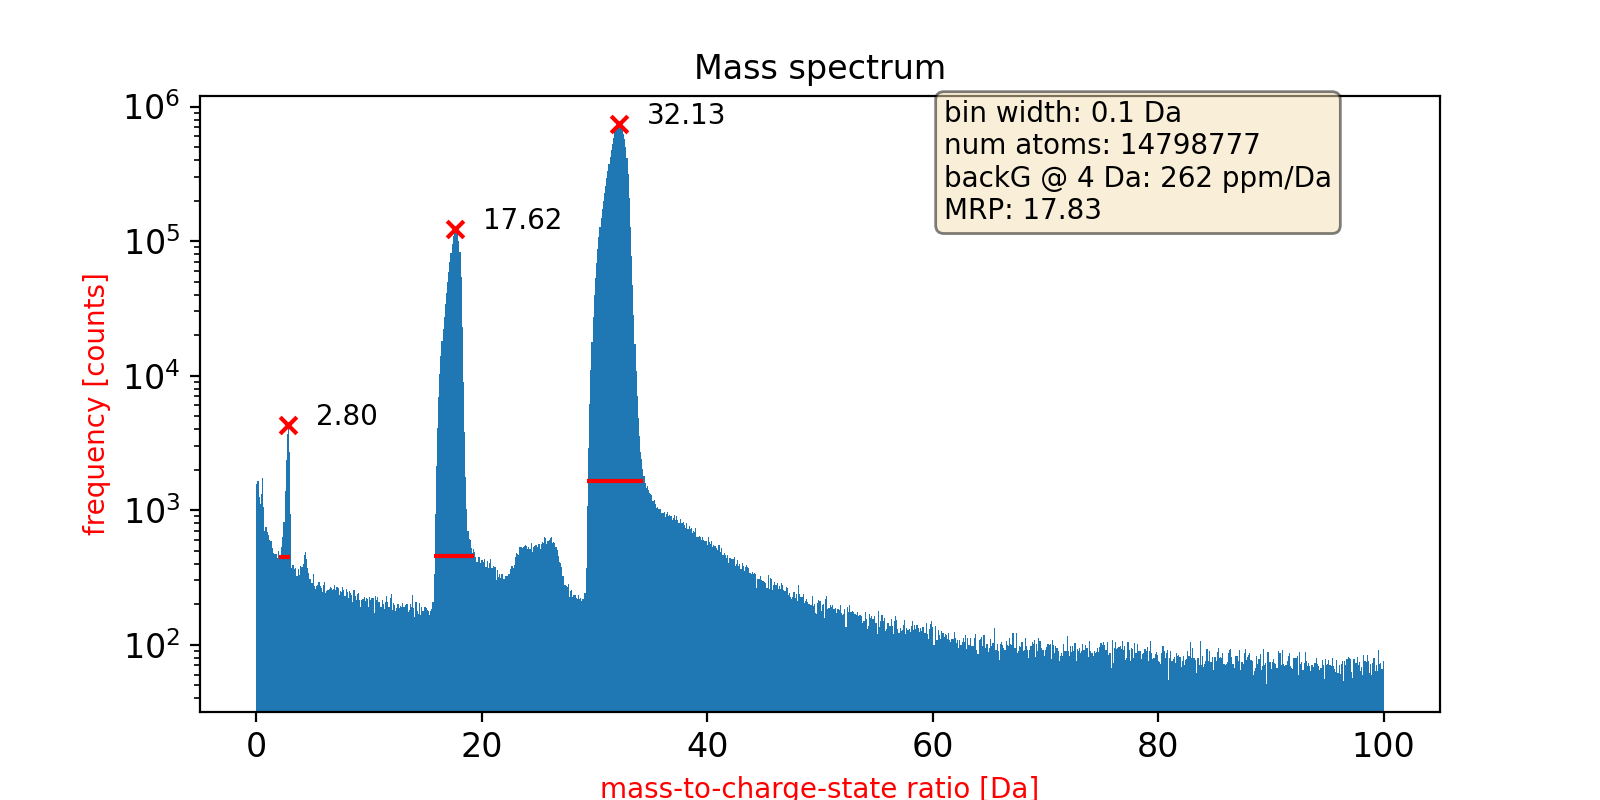

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [17.83333333]
Peaks  0 is: 2.80 peak window sides are: 2.50 - 3.00
Peaks  1 is: 17.62 peak window sides are: 17.02 - 18.12
Peaks  2 is: 32.13 peak window sides are: 31.13 - 32.93


In [3]:
mc_seb = mc_tools.tof2mc(dld_t, t0, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength, mode='voltage_pulse')
max_hist, left_right_peaks, peaks_sides, max_paek_edges = tools.massSpecPlot(mc_seb[mc_seb < 100], 0.1, percent=50, plot=True, prominence=500, fig_name=figname)
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides[i,2], peaks_sides[i,3]))

In [4]:
peak_ideal = [1.01, 13.49, 26.98]
pick_ions_plot = []

# creat mask for each peak base on the peak loc. and window size
for i in range(len(peaks_sides)):
    mask_tmp = np.logical_and((peaks_sides[i, 2] < mc_seb), (mc_seb < peaks_sides[i, 3]))
    if i == 0:
        lenght = len(mask_tmp[mask_tmp==True])

        indexes_mask_tmp_equal = np.where(mask_tmp==True)[0].tolist()
    else:    
        indexes_mask_tmp_equal = np.where(mask_tmp==True)[0].tolist()    
        indexes_mask_tmp_equal = np.random.choice(indexes_mask_tmp_equal, size=lenght, replace=False)
    
    
    bb = np.zeros(len(mc_seb))
    
    mc_seb_ideal_tmp = np.copy(bb)
    # put the location (mc) of the peak for all selected mc
    mc_seb_ideal_tmp[mask_tmp] = peak_ideal[i]
    
    pick_ions_plot.append(mask_tmp)
    if i == 0:
        mask = np.copy(mask_tmp)
        mc_seb_ideal = np.copy(mc_seb_ideal_tmp)
        mask_equal = indexes_mask_tmp_equal
    else:
        mask += mask_tmp
        mc_seb_ideal += mc_seb_ideal_tmp 
        mask_equal.extend(indexes_mask_tmp_equal)

<IPython.core.display.Javascript object>


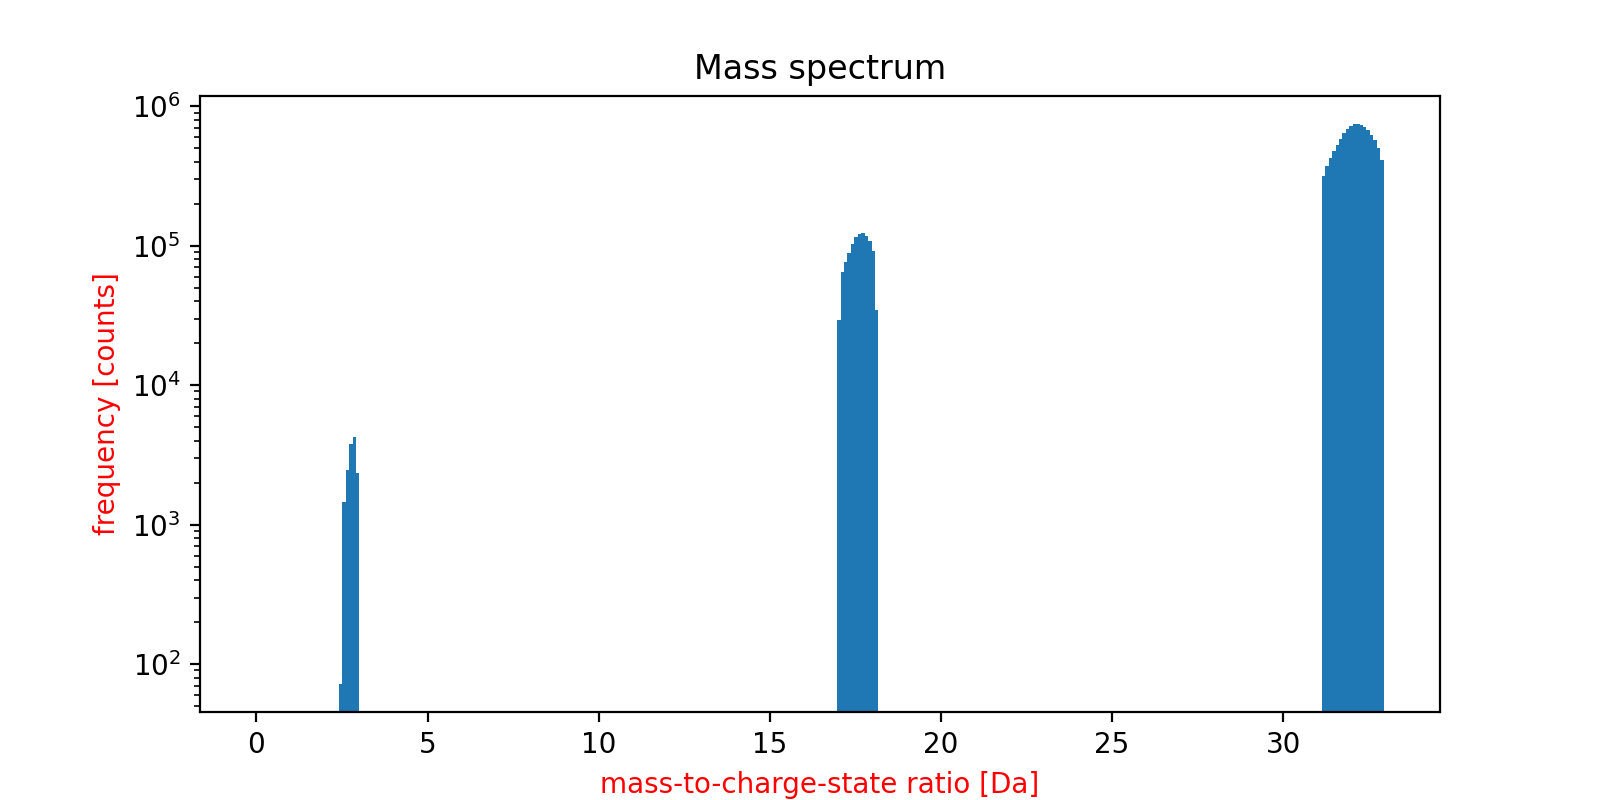

(0, 0, 0, 0)

In [5]:
mc_seb_masked = mc_seb[mask]
tools.massSpecPlot(mc_seb_masked[mc_seb_masked < 100], 0.1, peaks_find=False, plot=True)

<IPython.core.display.Javascript object>


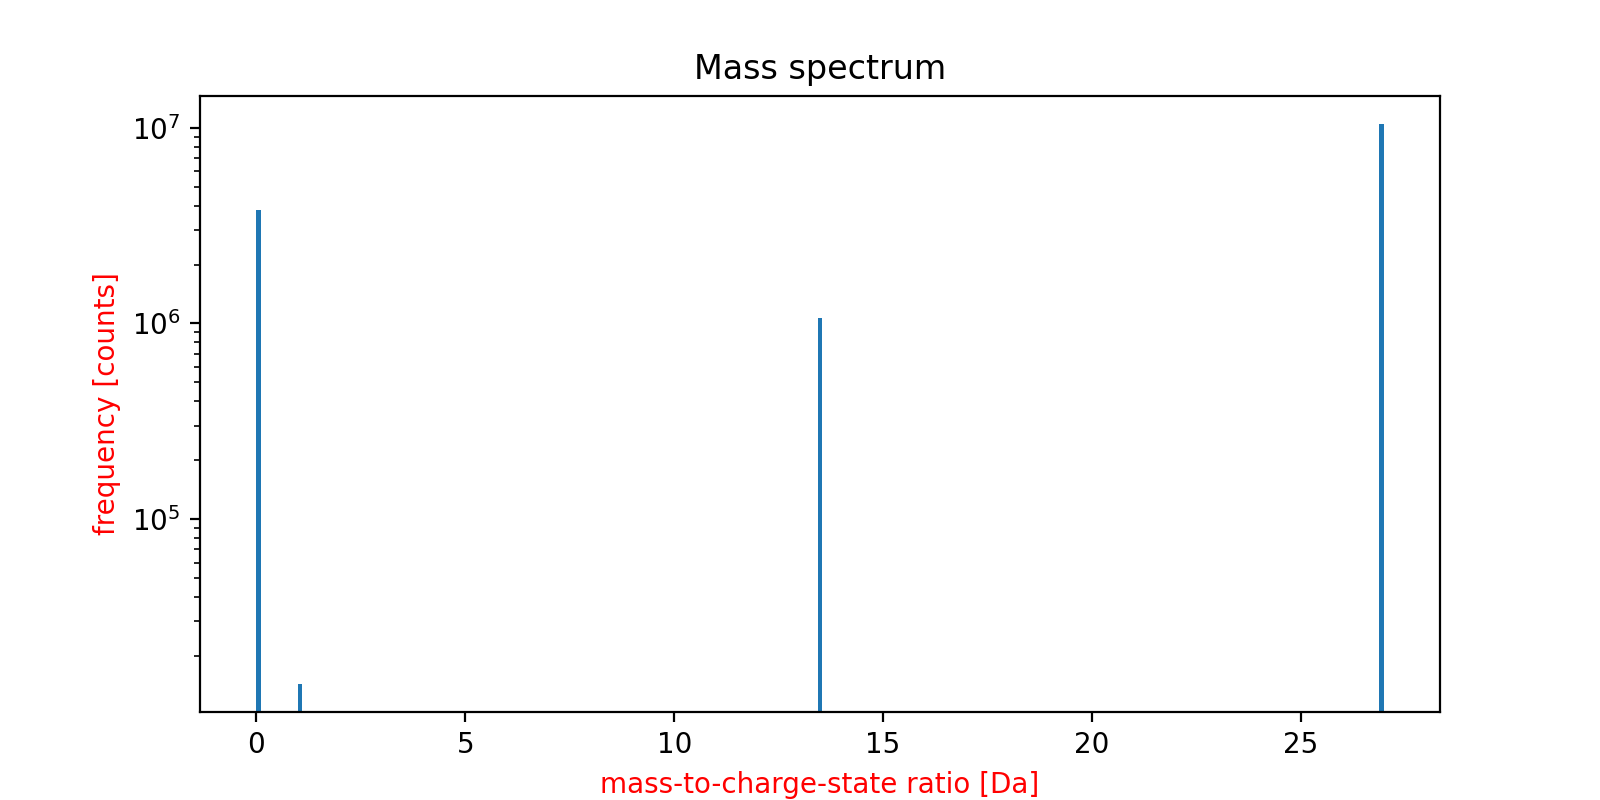

(0, 0, 0, 0)

In [6]:
tools.massSpecPlot(mc_seb_ideal, 0.1, peaks_find=False, plot=True)

<IPython.core.display.Javascript object>


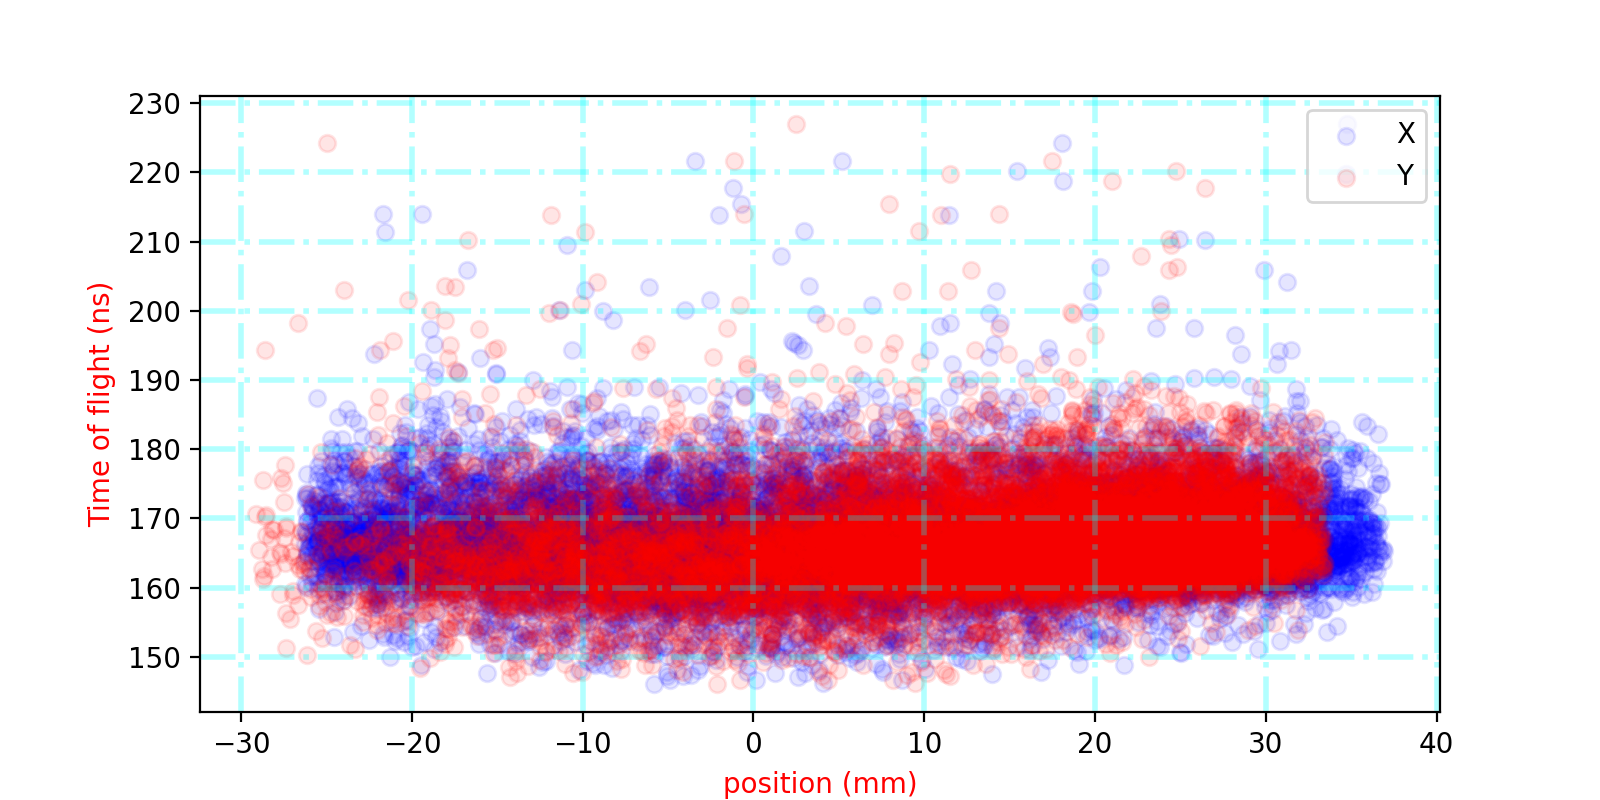

<IPython.core.display.Javascript object>


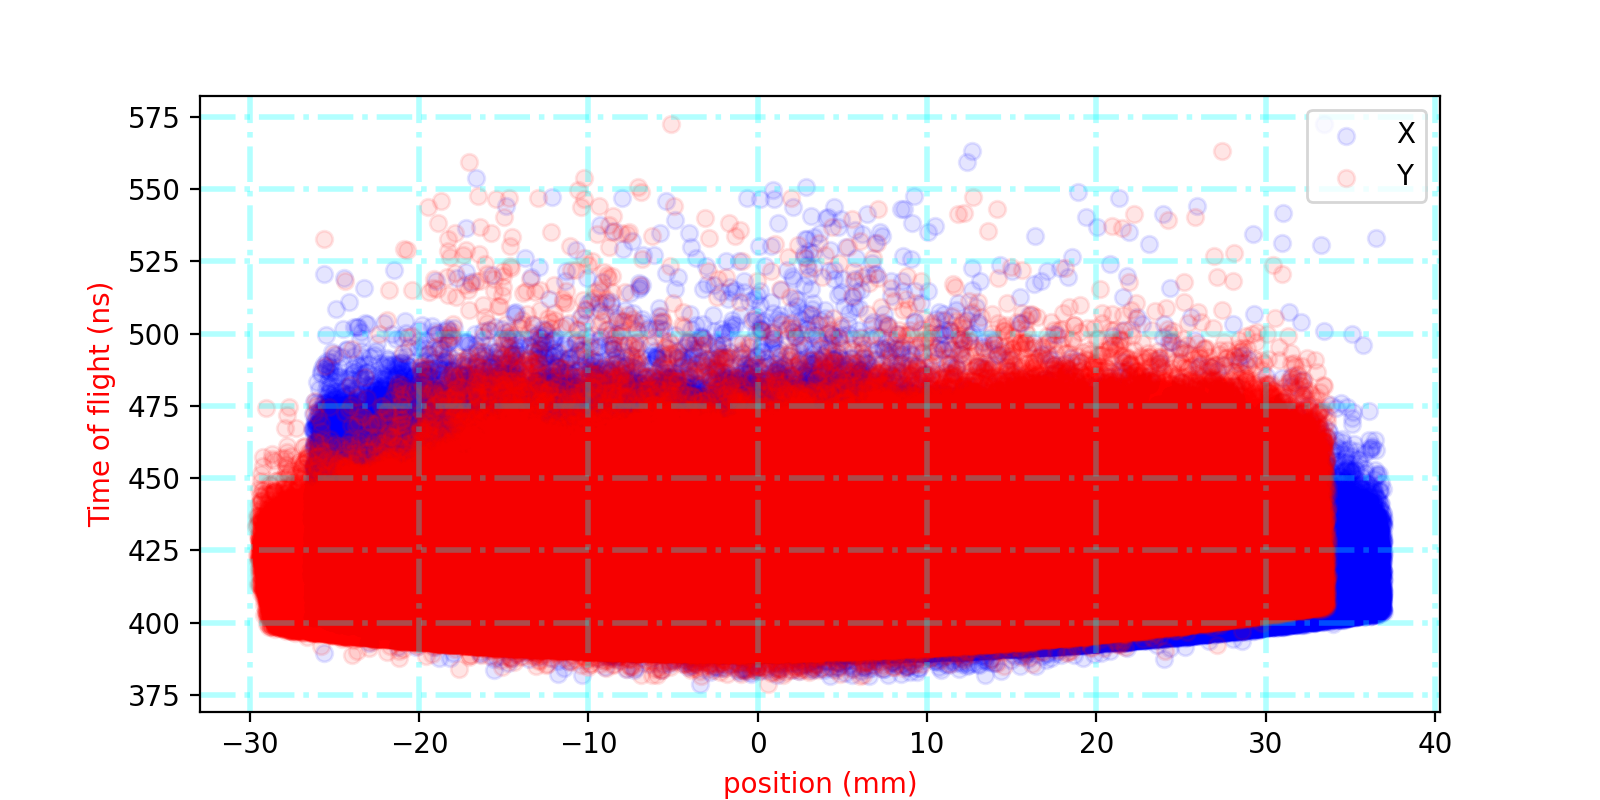

<IPython.core.display.Javascript object>


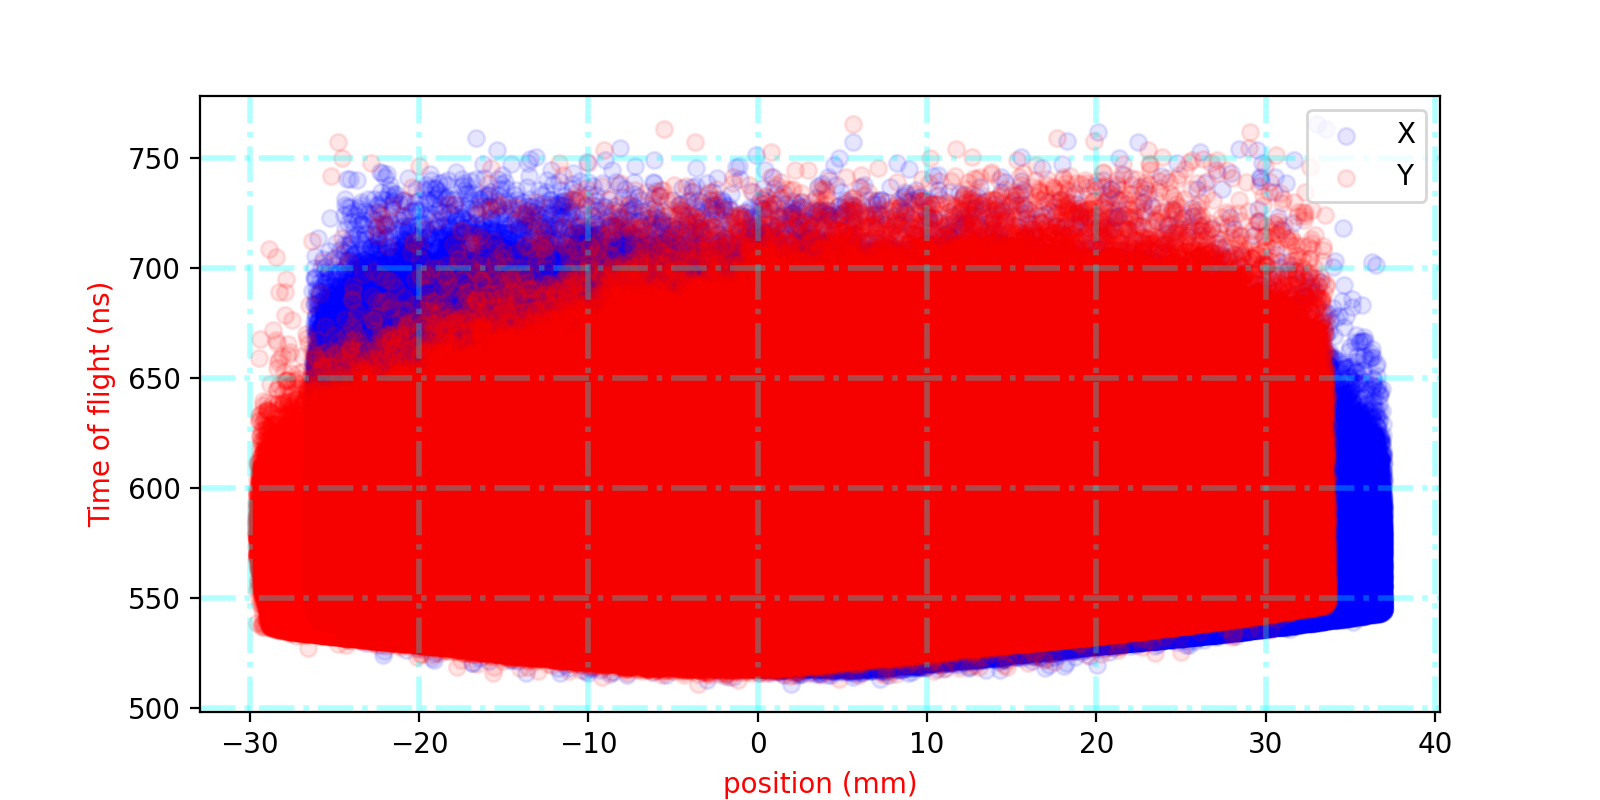

In [7]:
for i in range(len(pick_ions_plot)):
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    dld_x_masked = dld_x[pick_ions_plot[i]]
    dld_y_masked = dld_y[pick_ions_plot[i]]
    dld_t_masked = dld_t[pick_ions_plot[i]]
    x = plt.scatter(dld_x_masked, dld_t_masked, color="blue", label='X', alpha=0.1)
    y = plt.scatter(dld_y_masked, dld_t_masked, color="red", label='Y', alpha=0.1)
    ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
    ax1.set_xlabel("position (mm)", color="red", fontsize=10)
    plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
    plt.legend(handles=[x, y], loc='upper right')
#     plt.savefig('position_peak_%s' %i + "%s.svg" %figname, format="svg", dpi=1200)
#     plt.savefig('position_peak_%s' %i + "%s.png" %figname, format="png", dpi=1200)
    plt.show()

$$\frac{m}{n} = k\alpha (V_{dc} + \beta V_{pulse})(\frac{t + t_{0}}{d})^{2} $$<br>
$\mathbf{\text{Reformulate the equation:}}$<br>
$$t = d(\sqrt{\frac{\frac{m}{n}}{k\alpha (V_{dc}+\beta V_{pulse})}})-t_{0} $$<br>

<IPython.core.display.Javascript object>


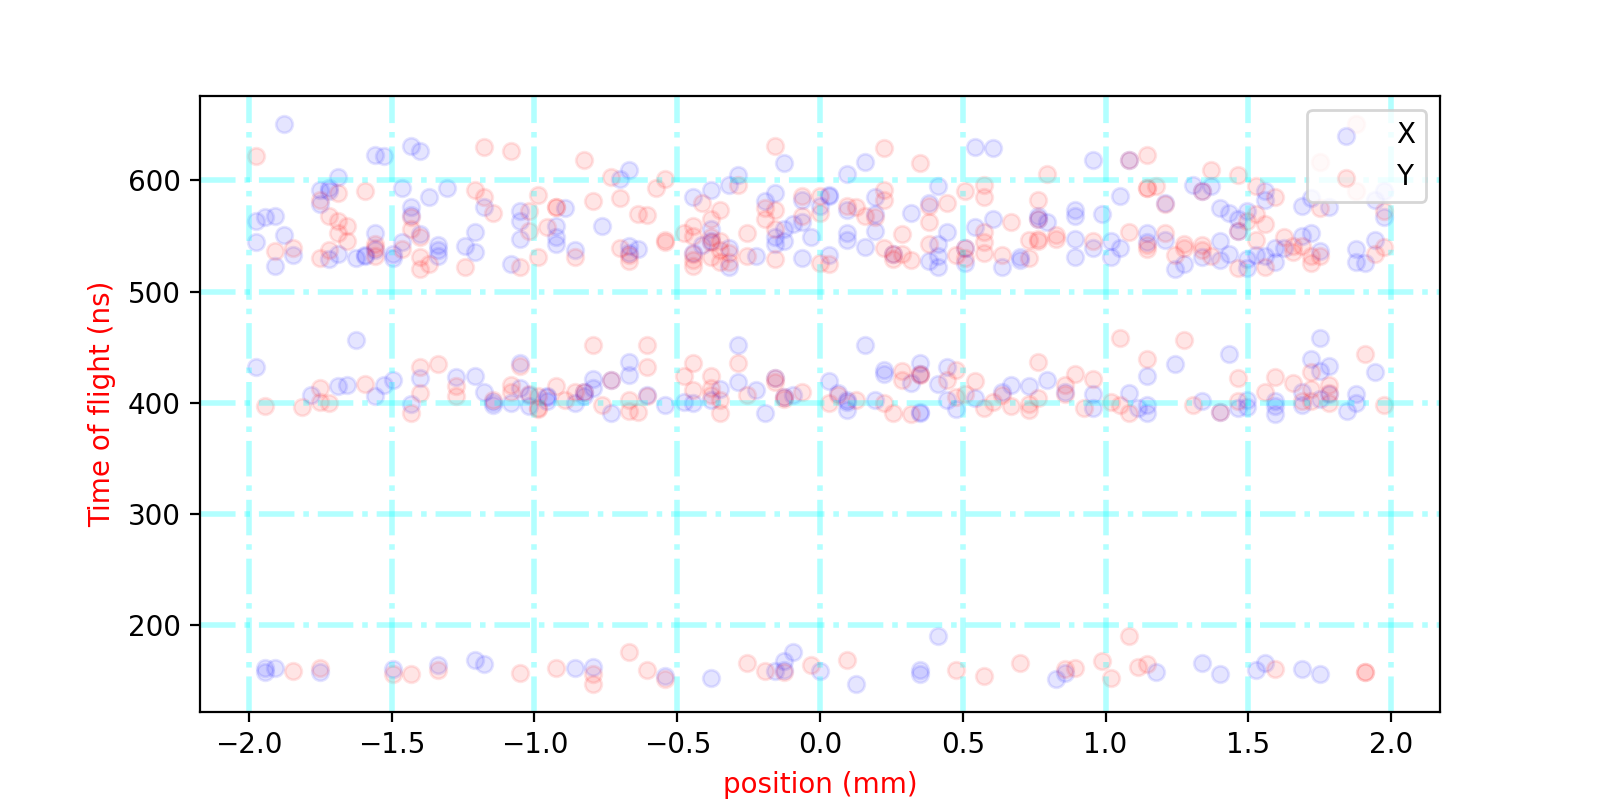

(292,)


In [8]:
# use mask_equal to have equal number of ions for each peak
# only peak the value in the center of detector 2mm * 2mm
detector_squre = 2
fig1, ax1 = plt.subplots(figsize=(8, 4))
dld_x_masked = dld_x[mask_equal]
dld_y_masked = dld_y[mask_equal]
dld_t_masked = dld_t[mask_equal]

mask_tmp_middle = np.logical_and((np.abs(dld_x_masked) < detector_squre), (np.abs(dld_y_masked) < detector_squre))
dld_x_masked = dld_x_masked[mask_tmp_middle]
dld_y_masked = dld_y_masked[mask_tmp_middle]
dld_t_masked = dld_t_masked[mask_tmp_middle]
print(dld_t_masked.shape)
x = plt.scatter(dld_x_masked, dld_t_masked, color="blue", label='X', alpha=0.1)
y = plt.scatter(dld_y_masked, dld_t_masked, color="red", label='Y', alpha=0.1)
ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
ax1.set_xlabel("position (mm)", color="red", fontsize=10)
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
plt.legend(handles=[x, y], loc='upper right')
plt.savefig('center_' + "%s.png" %figname, format="png", dpi=1200)
plt.show()


In [9]:
# use mask_equal to have equal number of ions for each peak
dld_highVoltage_masked = dld_highVoltage[mask_equal]
dld_pulseVoltage_masked = dld_pulseVoltage[mask_equal]

dld_highVoltage_masked = dld_highVoltage_masked[mask_tmp_middle]
dld_pulseVoltage_masked = dld_pulseVoltage_masked[mask_tmp_middle]

dld_x_masked = dld_x[mask_equal]
dld_y_masked = dld_y[mask_equal]
dld_t_masked = dld_t[mask_equal]


dld_x_masked = dld_x_masked[mask_tmp_middle]
dld_y_masked = dld_y_masked[mask_tmp_middle]
dld_t_masked = dld_t_masked[mask_tmp_middle]

mc_seb_reg_masked = mc_seb_ideal[mask_equal]
mc_seb_reg_masked = mc_seb_reg_masked[mask_tmp_middle]

seb_t = dld_t_masked * 1E-9  # tof in s
# seb_factor = np.sqrt(mc_seb_reg_ideal[mask_middle] * 1.66E-27 / (2 * 1.6E-19 * 1.015 * (dld_highVoltage_masked + 0.7 * dld_pulseVoltage_masked)))
seb_factor = np.sqrt(mc_seb_reg_masked * 1.66E-27 / (2 * 1.6E-19 * dld_highVoltage_masked))

In [ ]:
# np.save('seb_factor.npy', np.array([seb_factor]).squeeze(0).reshape(-1, 1) )
# np.save('seb_t.npy', np.array([seb_t]).squeeze(0))

In [10]:
seb_factor = seb_factor * 1E6
seb_t = seb_t * 1E9
huber = linear_model.HuberRegressor(alpha=1E-9,epsilon=1)
huber.fit(np.array([seb_factor]).squeeze(0).reshape(-1, 1), np.array([seb_t]).squeeze(0))
d_seb_huber = huber.coef_.item()
t0_seb_huber = huber.intercept_.item()          
print('Huber -- 2 the corrected flight path lenght(slop): {:.2f}'.format(d_seb_huber), '(mm)', '\nthe corrected t_0(intercept): {:.2f}'.format(t0_seb_huber), '(ns)')

bayesian_ridge = linear_model.Ridge(alpha=1)
bayesian_ridge.fit(np.array([seb_factor]).squeeze(0).reshape(-1, 1) , np.array([seb_t]).squeeze(0))
d_seb_rigid = bayesian_ridge.coef_.item()
t0_seb_rigid = bayesian_ridge.intercept_.item()         
print('Rigid -- the corrected flight path lenght(slop): {:.2f}'.format(d_seb_rigid), '(mm)', '\nthe corrected t_0(intercept): {:.2f}'.format(t0_seb_rigid), '(ns)')
# Train the model using the data sets ( linear regression)
linear = linear_model.LinearRegression()
linear.fit(np.array([seb_factor]).squeeze(0).reshape(-1, 1), np.array([seb_t]).squeeze(0))
d_seb = linear.coef_.item()
t0_seb = linear.intercept_.item()

print('Linear -- the corrected flight path lenght(slop): {:.2f}'.format(d_seb), '(mm)', '\nthe corrected t_0(intercept): {:.2f}'.format(t0_seb), '(ns)')
# Train the model using the data sets ( Lasso regression)
lasso = linear_model.Lasso(alpha=1)
lasso.fit(np.array([seb_factor]).squeeze(0).reshape(-1, 1), np.array([seb_t]).squeeze(0))
d_seb_lasso = lasso.coef_.item()
t0_seb_lasso = lasso.intercept_.item() 
print('Lasso -- the corrected flight path lenght(slop): {:.2f}'.format(d_seb_lasso), '(mm)', '\nthe corrected t_0(intercept): {:.2f}'.format(t0_seb_lasso), '(ns)')


Huber -- 2 the corrected flight path lenght(slop): 105.83 (mm) 
the corrected t_0(intercept): 67.20 (ns)
Rigid -- the corrected flight path lenght(slop): 105.47 (mm) 
the corrected t_0(intercept): 68.65 (ns)
Linear -- the corrected flight path lenght(slop): 105.72 (mm) 
the corrected t_0(intercept): 67.69 (ns)
Lasso -- the corrected flight path lenght(slop): 105.03 (mm) 
the corrected t_0(intercept): 70.33 (ns)


<IPython.core.display.Javascript object>


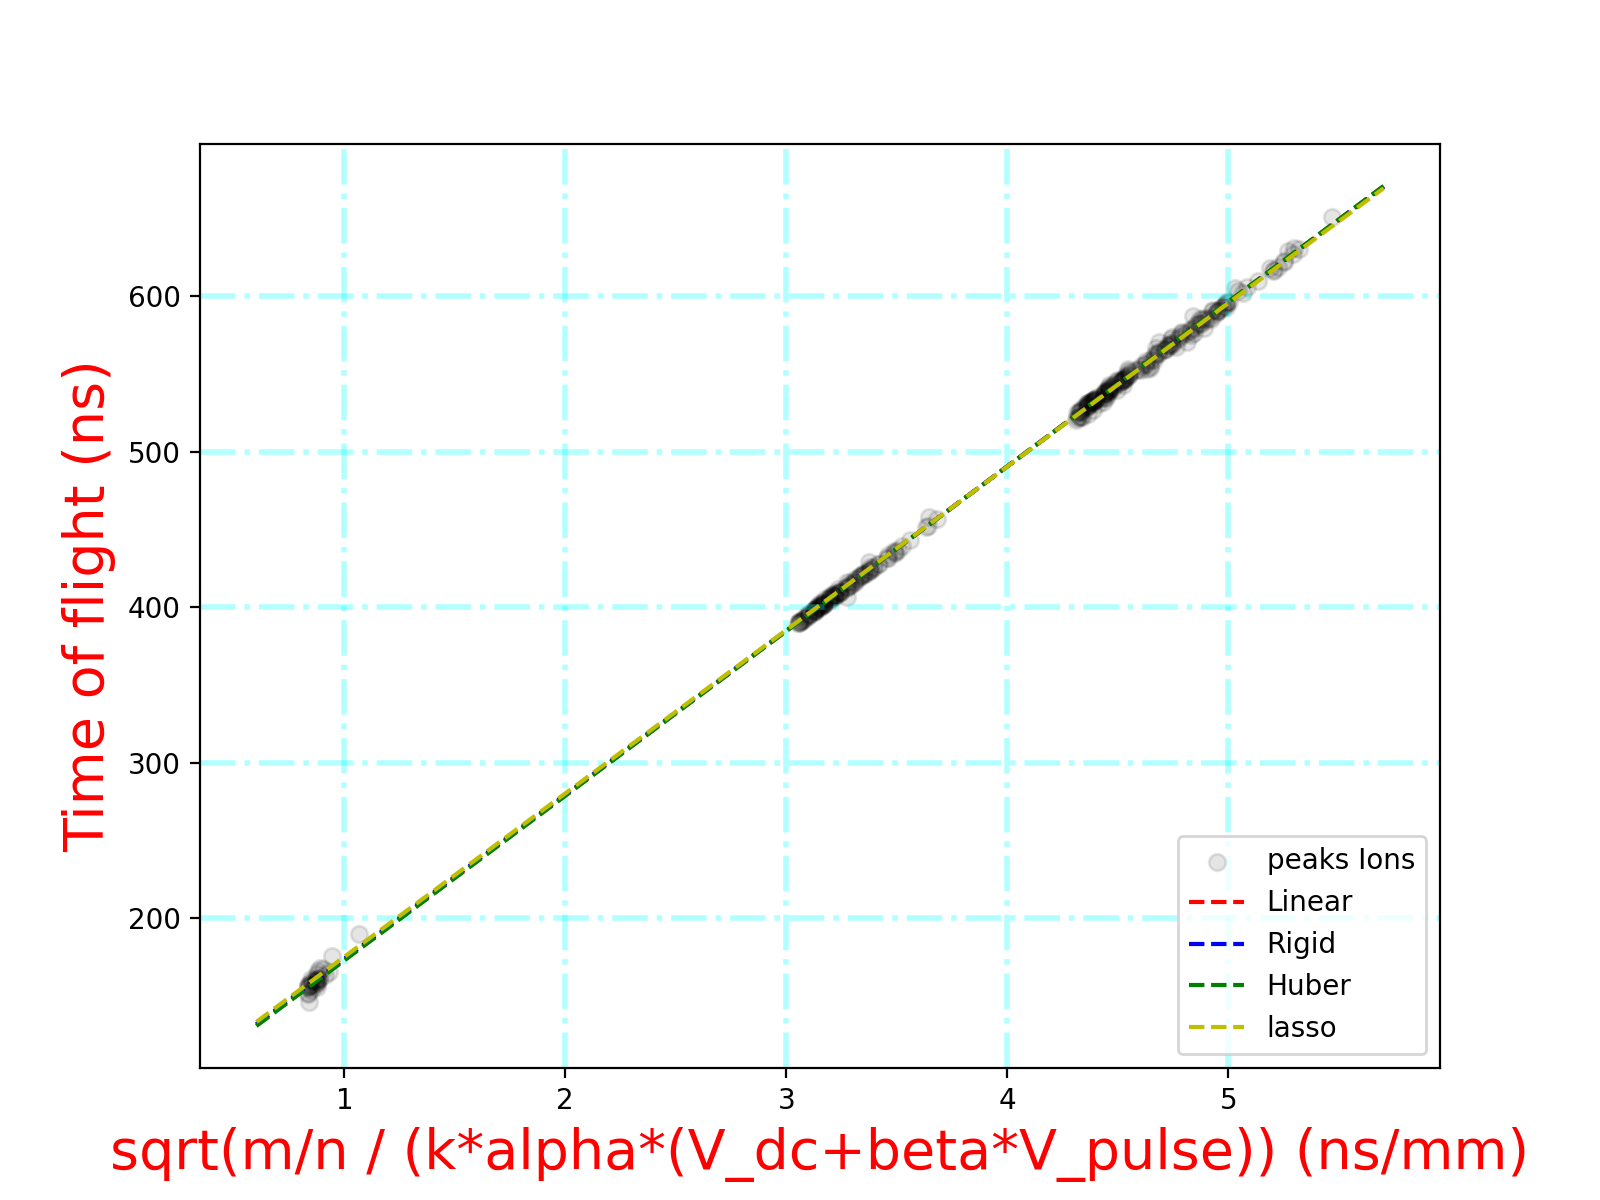

In [11]:
# Plot outputs
fig1, ax1 = plt.subplots(figsize=(8, 6))
peaks_data = plt.scatter(seb_factor, seb_t, color="black", label='peaks Ions', alpha=0.1)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
#y_vals = t0_seb + d_seb * np.squeeze(np.transpose(np.array([seb_factor])))
#x_vals = mc_seb_masked[mc_seb_masked < 100]

linear, = plt.plot(x_vals, t0_seb + d_seb * x_vals, '--', color='r', label='Linear' )
rigid, = plt.plot(x_vals, t0_seb_rigid + d_seb_rigid * x_vals, '--', color='b', label='Rigid' )
huber, = plt.plot(x_vals, t0_seb_huber + d_seb_huber * x_vals, '--', color='g', label='Huber' )
lasso, = plt.plot(x_vals, t0_seb_lasso + d_seb_lasso * x_vals, '--', color='y', label='lasso' )
# manual, = plt.plot(x_vals, 75 + 100 * x_vals, '--', color='y', label='manual' )
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
# plt.legend(handles=[peaks_data, linear, rigid, huber, manual], loc='lower right')
plt.legend(handles=[peaks_data, linear, rigid, huber,lasso], loc='lower right')
ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=20)
ax1.set_xlabel("sqrt(m/n / (k*alpha*(V_dc+beta*V_pulse)) (ns/mm)", color="red", fontsize=20)

#plt.savefig('regression' + "%s.svg" %figname, format="svg", dpi=1200)
#plt.savefig('regression' + "%s.png" %figname, format="png", dpi=1200)
plt.show()

In [12]:
# update flight path lenght
flightPathLength_new = float("{:.2f}".format(d_seb))
# update t_0
t0_new = float("{:.2f}".format(t0_seb))
print(flightPathLength_new, t0_new)

105.72 67.69


<IPython.core.display.Javascript object>


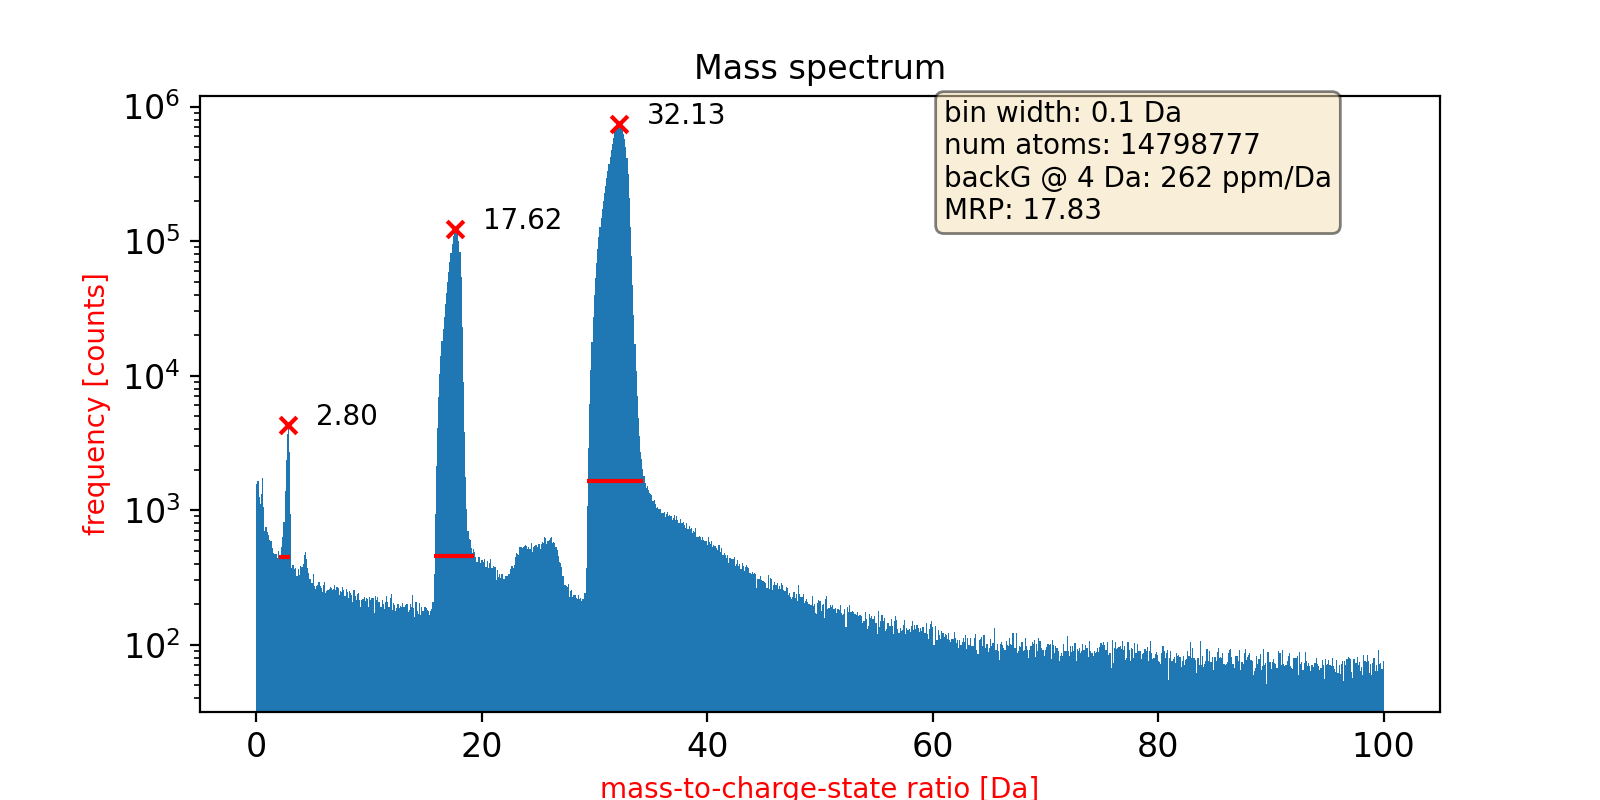

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [17.83333333]
Peaks  0 is: 2.80 peak window sides are: 2.50 - 3.00
Peaks  1 is: 17.62 peak window sides are: 17.02 - 18.12
Peaks  2 is: 32.13 peak window sides are: 31.13 - 32.93


In [13]:
# plot one more time mc with initial values
mc_seb_test = mc_tools.tof2mc(dld_t, t0, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength)
max_hist, left_right_peaks, peaks_sides, max_paek_edges = tools.massSpecPlot(mc_seb_test[mc_seb_test < 100], 0.1, percent=50, plot=True)
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides[i,2], peaks_sides[i,3]))

<IPython.core.display.Javascript object>


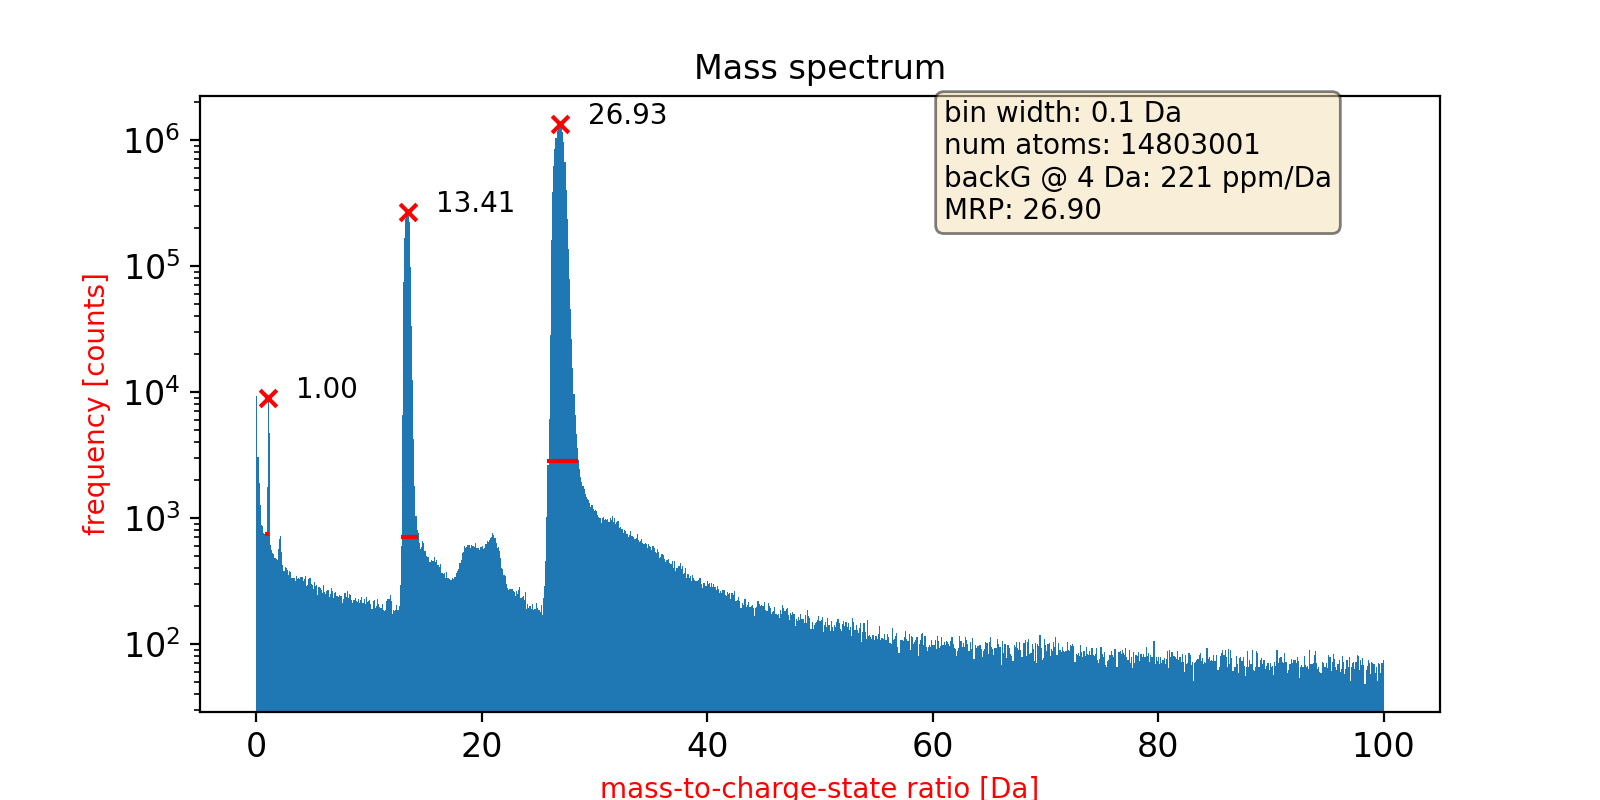

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [26.9]
Peaks  0 is: 1.00 peak window sides are: 0.90 - 1.20
Peaks  1 is: 13.41 peak window sides are: 13.01 - 13.61
Peaks  2 is: 26.93 peak window sides are: 26.33 - 27.33


In [14]:
# calculate the mc with new flight path lenght and t_0
mc_seb = mc_tools.tof2mc(dld_t, t0_new, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength_new)

max_hist, left_right_peaks, peaks_sides, max_paek_edges = tools.massSpecPlot(mc_seb[mc_seb < 100], 0.1, percent=50, plot=True, prominence=500, distance=None, fig_name='corrected_'+figname)
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides[i,2], peaks_sides[i,3]))